<span style="color:red;font-size:2em;font-weight:bold"> PARTIE 2 - Modélisation par classification</span>

<span style="color:blue;font-size:1.5em;font-weight:bold;background-color:yellow"> Modules </span>

In [1]:
# Roots
import numpy as np
import pandas as pd
# import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Stats
from scipy.stats import skew, kurtosis, zscore, chi2_contingency, f_oneway, chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
    StratifiedShuffleSplit,
    cross_val_predict,
    KFold,
    StratifiedKFold,
)
# Metrics
from sklearn.metrics import (
    accuracy_score, auc, classification_report, confusion_matrix, f1_score, fbeta_score, precision_recall_curve, 
    precision_score, recall_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay,make_scorer
)
# mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

# Feature importance
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, RobustScaler,PowerTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool

#SHAP
import shap


In [2]:
# Sert à éviter les Warnings avec les transformations sur des vues en transformant 
# ces warning en erreur obligeant ainsi à ne travailler que sur des copies ou les originaux.

pd.set_option('mode.chained_assignment','raise')

In [3]:
# Module pour recharger un module sans redemarrer le kernel
# import importlib
%load_ext autoreload
%autoreload 2

In [4]:
# Ajoute le dossier utils au sys.path. Remarque ne pas oublier le __init__.py dans le dossier utils
import sys
utils_path = Path.cwd().parent/"utils"
sys.path.append(str(utils_path))
# Fonctions personnelles
from filtering_counters import cleaning_counter, cleaning_results, removedAndAdded_col # Suivi des filtrage des features et observations
from plotting import create_fig, make_figure, graphs, graph_hyperParamEffect, graph_importance # Fonctions de plotting
from correlation import graphs_corr, CorrCouples_VIF, chi2_test, anova_test # Fonctions de correlation
from misc import features_types, data_props, top_score, iqr_outliers,zmad_outliers, model_attr# Divers fonctions
from ml_modeling import cat_modeling_cv, gridsearchcv, Xy_tf, preproc, cat_modeling_cv_predict, Xy_folds # Fonctions pour la modélisation

In [5]:
# Paramètres globaux
random_state = 42
save_results = False
cv= 5

In [6]:
# Importation des documents
Xy = pd.read_csv('../datas/results/Xy.csv')

In [7]:
Xy.head()

,age,genre,revenu_mensuel,statut_marital,poste,annees_dans_le_poste_actuel,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,...,niveau_education,domaine_etude,frequence_deplacement,evolution_note,stagnation_promo,freq_chgt_poste,revenu_mensuel_ajuste_par_nv_hierarchique,revenu_mensuel_par_annee_xp,freq_chgt_responsable,satisfaction_globale_employee
0,41,f,5993,célibataire,cadre commercial,4,oui,11,1,0,...,2,infra & cloud,occasionnel,0,0.000000,0.888889,2996.5,665.888889,0.833333,8
1,49,m,5130,marié(e),assistant de direction,7,non,23,0,1,...,1,infra & cloud,frequent,2,0.090909,5.000000,2565.0,466.363636,0.700000,12
2,37,m,2090,célibataire,consultant,0,oui,15,1,0,...,2,autre,occasionnel,1,0.000000,1.000000,2090.0,261.250000,0.000000,12
3,33,f,2909,marié(e),assistant de direction,7,oui,11,0,0,...,4,infra & cloud,frequent,0,0.333333,4.000000,2909.0,323.222222,0.000000,13
4,27,m,3468,marié(e),consultant,2,non,12,0,1,...,1,transformation digitale,occasionnel,0,0.666667,0.600000,3468.0,495.428571,1.000000,10


<span style="color:blue;font-size:1.5em;font-weight:bold;background-color:yellow"> Modélisation </span>

In [8]:
# Définition des prédicteurs X et de la cible y
X = Xy.drop(columns=['a_quitte_l_entreprise'])
y = Xy['a_quitte_l_entreprise']

In [9]:
# Identification des features numériques et catégorielles
numeric_list, cat_list = features_types(X)

In [10]:
# Dictionnaire de modèles
models_full = {
    'dummy': DummyClassifier(strategy='stratified'), #défaut prior: inutilisable car prédit uniquement la classe majoritaire
    'logisReg': LogisticRegression(random_state=random_state,
                                   solver='liblinear',
                                  ), # defaut lbfgs: supporte mal le déséquilibre des classes
    'svc': SVC(random_state=random_state, #defaut = None
               class_weight = "balanced", # défaut None: Sensible au déséquilibre des classes
               probability=True, # Ajoute le predict_proba
              ),
    'rf': RandomForestClassifier(n_estimators=100, #defaut = 100
                                random_state=random_state,#defaut = None
                               ),
    'gb': GradientBoostingClassifier(n_estimators=100,#defaut = 100
                                    random_state=random_state,#defaut = None
                                ),
    'cb': CatBoostClassifier(random_state=random_state,#defaut = None
                             logging_level='Silent' # Evite de printer 1 milliard de ligne de progression
                                )
}

dummy, logis et svc sont les seuls à ne pas fonctionner par défaut à cause du déséquilibre de classe (ne s'interesse qu'à la classe majoritaire ou est trop sensible aux dééquilibres).

In [11]:
scoring = {
        'accu':'accuracy',
        'f1':'f1',
        'prec':'precision',
        'recall':'recall',
        'roc_auc':'roc_auc',
    }

In [12]:
# Dictionnaire pour stocker les différents résultats
comparison_results_cv_dict = {}
for scaler_tf in [None,RobustScaler()]:
    print(f'===========Cas scaler_tf: {scaler_tf}===========')
    comparison_results_cv_dict[f'{scaler_tf}'] = cat_modeling_cv(
        X,
        y,
        numeric_list,
        cat_list,
        models_full,
        scaler_tf = scaler_tf,
        show=False,
        scoring=scoring,
    )[4] # Ne relève que le dataframe

===========Cas scaler_tf: None===========
Modèle : dummy en cours
Modèle : logisReg en cours
Modèle : svc en cours
Modèle : rf en cours
Modèle : gb en cours
Modèle : cb en cours
===========Cas scaler_tf: RobustScaler()===========
Modèle : dummy en cours
Modèle : logisReg en cours
Modèle : svc en cours
Modèle : rf en cours
Modèle : gb en cours
Modèle : cb en cours


In [13]:
# Regroupement des combinaisons dans une seule dataframe
comparison_results_cv_concat = pd.concat(
    [df.assign(Source=key) for key, df in comparison_results_cv_dict.items()], 
    ignore_index=True
)
comparison_results_cv_concat

,Modele,accu_train,accu_test,f1_train,f1_test,prec_train,prec_test,recall_train,recall_test,roc_auc_train,roc_auc_test,Source
0,dummy,0.731633,0.723129,0.164709,0.089433,0.166352,0.095670,0.164573,0.084309,0.499371,0.508000,None
1,logisReg,0.886905,0.871429,0.507174,0.422980,0.851231,0.770635,0.362824,0.295745,0.847018,0.823692,None
2,svc,0.660204,0.657823,0.365751,0.364560,0.261654,0.260886,0.607597,0.607624,0.670723,0.660251,None
3,rf,1.000000,0.860544,1.000000,0.321423,1.000000,0.743524,1.000000,0.207181,1.000000,0.810386,None
4,gb,0.950680,0.863946,0.821611,0.428167,0.985361,0.673039,0.704667,0.316755,0.981986,0.811699,None
5,cb,0.981293,0.874150,0.938337,0.426978,1.000000,0.791752,0.883960,0.295922,0.999403,0.815348,None
6,dummy,0.732313,0.714966,0.156277,0.148940,0.159507,0.146885,0.154002,0.151950,0.497129,0.517657,RobustScaler()
7,logisReg,0.892007,0.882993,0.573218,0.541173,0.789258,0.732647,0.450398,0.430496,0.864578,0.840091,RobustScaler()
8,svc,0.906973,0.819048,0.761233,0.526772,0.650089,0.455699,0.918769,0.624645,0.969695,0.822456,RobustScaler()
9,rf,1.000000,0.861224,1.000000,0.322514,1.000000,0.751613,1.000000,0.207181,1.000000,0.809915,RobustScaler()


In [14]:
ind_pond = [i for i in comparison_results_cv_concat.columns if '_test' in i]
weight_pond = [
    [1,1],
    [1,1],
    [1,1],
    [1,1],
    [1,1],
]

In [15]:
top_param_equi, top_model_equi=top_score(
    data = comparison_results_cv_concat,
    ind_pond = ind_pond,
    weight_pond = weight_pond,
    ind_ref = 'Modele',
    cols = ['recall_test','Source'],
    topN = 5,
)
print('==============Classement suivant les paramètres==============')
display(top_param_equi)
print('==============Classement absolu==============')
display(top_model_equi)

==============Classement suivant les paramètres==============


,Modele,recall_test,Source,score
0,logisReg,3.0,RobustScaler(),2.4
1,cb,6.0,RobustScaler(),3.6
2,cb,6.0,None,3.8
3,logisReg,8.0,None,4.8
4,svc,1.0,RobustScaler(),4.8
5,gb,4.0,RobustScaler(),5.0
6,gb,4.0,None,5.2
7,rf,9.0,RobustScaler(),7.6
8,rf,9.0,None,8.0
9,svc,2.0,None,8.4


==============Classement absolu==============


Modele
logisReg     3.6
cb           3.7
gb           5.1
svc          6.6
rf           7.8
dummy       11.3
Name: score, dtype: float64

In [16]:
weight_pond_only_recall = [
    [0,1],
    [0,1],
    [0,1],
    [1,1],
    [0,1],
]

In [17]:
top_param_recall, top_model_recall=top_score(
    data = comparison_results_cv_concat,
    ind_pond = ind_pond,
    weight_pond = weight_pond_only_recall,
    ind_ref = 'Modele',
    cols = ['recall_test','Source'],
    topN = 5,
)
print('==============Classement suivant les paramètres==============')
display(top_param_recall)
print('==============Classement absolu==============')
display(top_model_recall)

==============Classement suivant les paramètres==============


,Modele,recall_test,Source,score
0,svc,1.0,RobustScaler(),1.0
1,svc,2.0,None,2.0
2,logisReg,3.0,RobustScaler(),3.0
3,gb,4.0,None,4.0
4,gb,4.0,RobustScaler(),4.0
5,cb,6.0,RobustScaler(),6.0
6,cb,6.0,None,6.0
7,logisReg,8.0,None,8.0
8,rf,9.0,None,9.0
9,rf,9.0,RobustScaler(),9.0


==============Classement absolu==============


Modele
svc          1.5
gb           4.0
logisReg     5.5
cb           6.0
rf           9.0
dummy       11.5
Name: score, dtype: float64

**Reformulation des métriques:**  
- **Exactitude**: $\frac{\text{Nb total de valeurs correctement classifiées}}{\text{Nb total de valeurs}} = \frac{TP+TN}{TP+TN+FP+FN}$  
Représente la capacité du modèle a prédire correctement.
- **f1**: Cas particulier du $f_\beta$, où $\beta = 1$ tel que $f_1=2\times\frac{\text{Précision x Rappel}}{\text{Précision + Rappel}} = \frac{TP}{TP+0.5(FP+FN)}$  
Le f-score évalue la performance du modèle suivant ses scores de précision et de rappel pondérés par $\beta$. Dans le cas du f1 on est sur une équipondération. Le score sera donc d'autant plus élevé que les deux métriques le seront mais aussi dégradé dès lors qu'une des métriques le sera.
- **Précision**: $\frac{\text{Nb de valeurs de classe positive correctement prédites}}{\text{Nb total de valeurs de classe positive prédites}} = \frac{TP}{TP+FP}$  
Représente la proportion de vrais positif parmis ceux que le modèle à identifié comme tel.
- **Rappel**:$\frac{\text{Nb de valeurs de classe positive correctement prédites}}{\text{Nb total de valeurs de la classe positive dans le jeu}} = \frac{TP}{TP+FN}$  
Représente la proportion de vrais positif existant que le modèle à réussi à correctement identifier.
- **ROC-AUC**: Le ROC (Receiver Operating Characteristic) représente la relation entre le taux de vrai positif (TPR) qui correpsond aussi au rappel et le taux de faux positif (FPR) tel que:  
$\text{f(FPR)} = \text{TPR}$.  
L'AUC quant à elle représente l'aire sous la courbe ainsi, lorsqu'on parle de ROC-AUC, on cherche à calculer l'aire sous la courbe ROC:  
$\text{ROC-AUC} = \int_{0}^{1} \text{TPR(FPR) d(FPR)}$
Plus le score tend vers 1, plus le modèle sépare corectement les classes et inversement plus la valeur tend vers 0.5 et plus c'est aléatoire.

- Dans le contexte général, la démission est un cas peu répandu (par rapport au nombre d'employés) ==> en général c'est la classe minoritaire. De plus le contexte métier voudrait qu'il est préférable d'avoir identifié tous les démissionaires quitte à avoir prédit des non-démissionnaires en plus afin d'être préparer au turn over que l'inverse: **on préfèrera donc sur-évaluer les départs ==> préférable d'avoir un FP accru qu'un FN accru ==> On préfère avoir un rappel elevé (on limite FN) qu'une précision elevé (on délaisse FP)**.
- Globalement tous les modèles font mieux que la baseline à part le score d'exactitude de svc sans standardisation.
- La standardisation n'a quasi aucune influence sur les modèles de foret alétoire. Elle permet par contre de grandement améliorer le modèle svc dans toutes ses stats. A la différence du reste, la regression logistique voit sa précision légèrement dégradée mais voit son rappel quasiment doublé ce qui améliore dans le même temps son score f1 en ré-équilibrant les métriques précision/rappel.
- On observation un overfit flagrant très prononcé sur le recall (aussi sur la précision mais moins importante) pour les modèles d'arbres et au contraire avec le modèle logistique et svc, on observe une très bonne robustesse avec des résultats test/train sensiblement pareils.
- En classement absolu équipondéré, la regression logistique performe le mieux suivi du catboost tandis que si on se concentre seulement sur le rappel, le modèle svc bat largement tous les autres modèles suivi de loin par le gradientboositng.

- *NOTE: Probablement dû au déséquilibre des classes, les méthodes par défaut des modèles dummy, logistic et svc retournent une UndefinedMetricWarning car le modèle distingue mal les classes voir n'identifie que la classe majoritaire (dans notre cas, ils ne percoivent que la classe négative == ce sont donc les employés toujours en poste).*
- *NOTE2: Par défaut, les outils comme cross_validate, cross_val_predict et GridSearchCV utilise le splitter KFold en regression et StratifiedKFold en classification. Bien que la stratification soit faite, cela n'empeche pas le déséquilibre des classes au sein des folds mais permet juste de maintenir la même proportion que le set original*

In [18]:
# Dictionnaire pour stocker les différents résultats
comparison_results_cv_dict_y_pred = {}
for scaler_tf in [None,RobustScaler()]:
    print(f'===========Cas scaler_tf: {scaler_tf}===========')
    comparison_results_cv_dict_y_pred[f'{scaler_tf}'] = cat_modeling_cv_predict(
        X,
        y,
        numeric_list,
        cat_list,
        models_full,
        scaler_tf = scaler_tf,
        show=False,
        class_threshold = 0.5
    )

===========Cas scaler_tf: None===========
Modèle : dummy en cours
Modèle : logisReg en cours
Modèle : svc en cours
Modèle : rf en cours
Modèle : gb en cours
Modèle : cb en cours
===========Cas scaler_tf: RobustScaler()===========
Modèle : dummy en cours
Modèle : logisReg en cours
Modèle : svc en cours
Modèle : rf en cours
Modèle : gb en cours
Modèle : cb en cours


In [19]:
# Regroupement des combinaisons dans une seule dataframe
comparison_results_cv_concat_y_pred = pd.concat(
    [df.assign(Source=key) for key, df in comparison_results_cv_dict_y_pred.items()], 
    ignore_index=True
)
comparison_results_cv_concat_y_pred

,Modele,y_pred_proba,y_pred,Source
0,dummy,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",None
1,logisReg,"[[0.4566516689730734, 0.5433483310269266], [0....","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",None
2,svc,"[[0.9060218474082289, 0.09397815259177097], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",None
3,rf,"[[0.71, 0.29], [0.92, 0.08], [0.56, 0.44], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",None
4,gb,"[[0.46229503023882745, 0.5377049697611725], [0...","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...",None
5,cb,"[[0.4893367548026173, 0.5106632451973827], [0....","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",None
6,dummy,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",RobustScaler()
7,logisReg,"[[0.387812133124966, 0.612187866875034], [0.97...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",RobustScaler()
8,svc,"[[0.7189336910269104, 0.2810663089730896], [0....","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",RobustScaler()
9,rf,"[[0.71, 0.29], [0.92, 0.08], [0.56, 0.44], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",RobustScaler()


In [20]:
# Matrice de confusion suivant les différents modèles et paramètres utilisés
for i in range(len(comparison_results_cv_concat_y_pred['Modele'])):
    print(f'Matrice de confusion ([True Negative, False Positive],\n'\
    f'                      [False Negative, True Positive]) \n{comparison_results_cv_concat_y_pred.loc[i,['Modele','Source']]}')
    
    display(confusion_matrix(y,pd.Series(comparison_results_cv_concat_y_pred.loc[i,'y_pred'])))

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele    dummy
Source     None
Name: 0, dtype: object


array([[1021,  212],
       [ 192,   45]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele    logisReg
Source        None
Name: 1, dtype: object


array([[1211,   22],
       [ 167,   70]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele     svc
Source    None
Name: 2, dtype: object


array([[1233,    0],
       [ 237,    0]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele      rf
Source    None
Name: 3, dtype: object


array([[1215,   18],
       [ 187,   50]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele      gb
Source    None
Name: 4, dtype: object


array([[1195,   38],
       [ 162,   75]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele      cb
Source    None
Name: 5, dtype: object


array([[1215,   18],
       [ 167,   70]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele             dummy
Source    RobustScaler()
Name: 6, dtype: object


array([[1042,  191],
       [ 205,   32]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele          logisReg
Source    RobustScaler()
Name: 7, dtype: object


array([[1196,   37],
       [ 135,  102]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele               svc
Source    RobustScaler()
Name: 8, dtype: object


array([[1197,   36],
       [ 160,   77]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele                rf
Source    RobustScaler()
Name: 9, dtype: object


array([[1215,   18],
       [ 187,   50]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele                gb
Source    RobustScaler()
Name: 10, dtype: object


array([[1195,   38],
       [ 162,   75]])

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modele                cb
Source    RobustScaler()
Name: 11, dtype: object


array([[1215,   18],
       [ 167,   70]])

**Rappel: On veut maximiser TP qui a ce que FP croisse aussi que FN croisse**  
Matrice de confusion :

\begin{array}{|c|c|}
\hline
\text{True Negative} & \text{False Positive} \\
\hline
\textbf{False Negative} & \textbf{\textcolor{red}{True Positive}}  \\
\hline
\end{array}

On **maximise TP** et on **minimise FN**: du coup on peut dire que le meilleur modèle pour notre problématique est la ***régression logistique en standardisée*** qui relève 139 démissions dont 102 réelles (73% de démissions réelles parmi les prédites) pour 135 démissionaires ratés (taux de réussite de prédiction de la classe positive de 43%).  
Si on ne considère que les modèles non-linéaires alors c'est le ***GradientBoosting*** avec avec 103 démissionaires prédit pour 75 qui le sont vraiment (73%) et 162 démissionnaires non-identifiés soit (taux de réussite de 32%).

*NOTE: On peut observer que le modèle SVC sans standardisation loupe totalement la classe minoritaire ce qui devrait se traduire par une précision incalculable*

In [21]:
for i in range(len(comparison_results_cv_concat_y_pred['Modele'])):
    print('='*60)
    print(f'{comparison_results_cv_concat_y_pred.loc[i,'Modele']} {comparison_results_cv_concat_y_pred.loc[i,'Source']}')
    print(classification_report(
        y_true = y,
        y_pred = comparison_results_cv_concat_y_pred.loc[i,'y_pred'],
        target_names=['non-démissionnaire','démissionnaire'],
        zero_division = np.nan
    ))

dummy None
                    precision    recall  f1-score   support

non-démissionnaire       0.84      0.83      0.83      1233
    démissionnaire       0.18      0.19      0.18       237

          accuracy                           0.73      1470
         macro avg       0.51      0.51      0.51      1470
      weighted avg       0.73      0.73      0.73      1470

logisReg None
                    precision    recall  f1-score   support

non-démissionnaire       0.88      0.98      0.93      1233
    démissionnaire       0.76      0.30      0.43       237

          accuracy                           0.87      1470
         macro avg       0.82      0.64      0.68      1470
      weighted avg       0.86      0.87      0.85      1470

svc None
                    precision    recall  f1-score   support

non-démissionnaire       0.84      1.00      0.91      1233
    démissionnaire        nan      0.00      0.00       237

          accuracy                           0.84      147

- precision de svc none incalculable comme mentionné précédemment ce qui casse aussi les autres métriques.
- meilleur recall sur logisReg robustscaler() avec 0.43.
- meilleur recall en non lineaire avec gradienboosting avec 0.32.

<span style='color:purple;font-weight:bold'> graphiques </span>

In [22]:
# plt.figure(figsize=(12,10))

# for i in range(len(comparison_results_cv_concat_y_pred['Modele'])):
#     PrecisionRecallDisplay.from_predictions(
#         y,
#         comparison_results_cv_concat_y_pred.loc[i,'y_pred_proba'][:,1],
#         name = comparison_results_cv_concat_y_pred.loc[i,'Modele'] +' ' + comparison_results_cv_concat_y_pred.loc[i,'Source'],
#         ax=plt.gca(),
#     )
# plt.title('Courbe PR suivant différents modèles et transformation')
# plt.xlabel('recall')
# plt.ylabel('precision')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

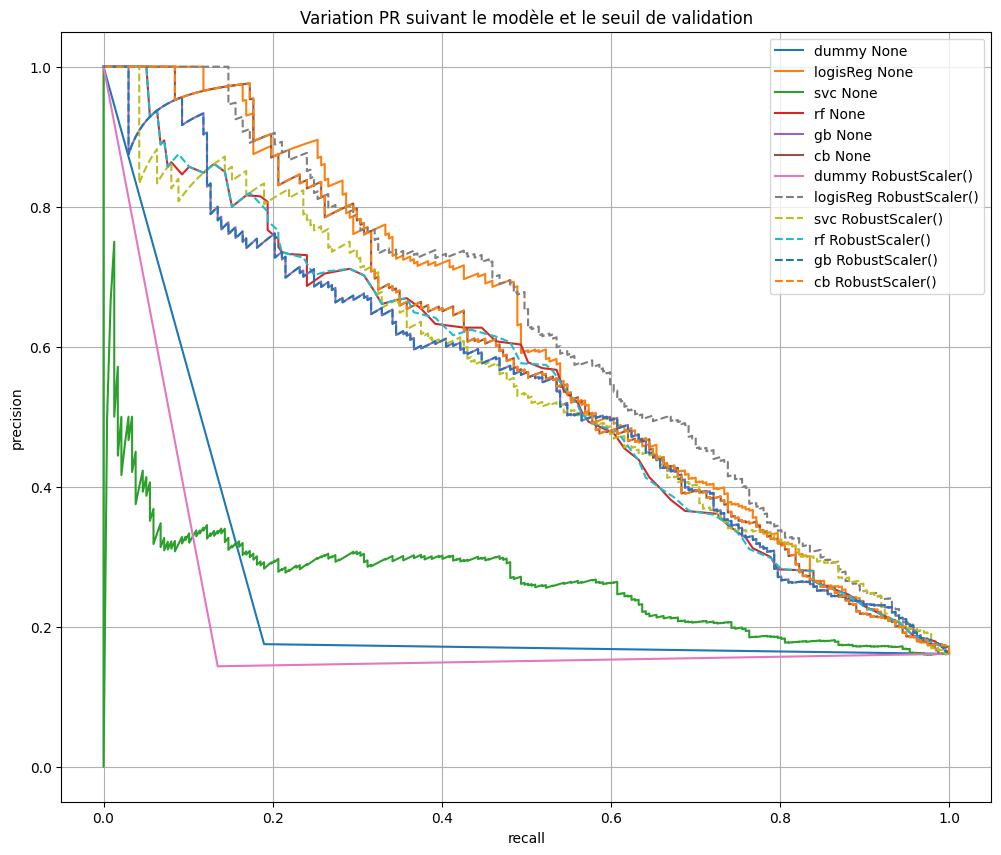

In [23]:
# Courbe PR (même résultat mais fonction différente juste) -- Recherche d'un seuil de validation optimisé

target_recall = 0.7 # Rappel cible
threshold_tuning_dict = []

plt.figure(figsize=(12,10))
for i in range(len(comparison_results_cv_concat_y_pred['Modele'])):

    precision,recall,thresholds = precision_recall_curve(y,comparison_results_cv_concat_y_pred.loc[i,'y_pred_proba'][:,1])
    idx = np.argmin(np.abs(recall-target_recall)) # On relève l'indice de l'écart min recall/recall cible
    opt_threshold = thresholds[idx] if idx < len(thresholds) else 1.0
    name = f'{comparison_results_cv_concat_y_pred.loc[i,'Modele']} {comparison_results_cv_concat_y_pred.loc[i,'Source']}'
    threshold_tuning_dict.append({
        'Nom': name,
        'Précision' : precision[idx],
        'Rappel': recall[idx],
        'Seuil_optimal' : opt_threshold
    })

    plt.plot(recall,precision,label=name, linestyle = 'solid' if i <=6 else 'dashed')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Variation PR suivant le modèle et le seuil de validation')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
# # Courbe Rappel sur seuil
# plt.figure(figsize=(12,10))
# for i in range(len(comparison_results_cv_concat_y_pred['Modele'])):

#     precision,recall,thresholds = precision_recall_curve(y,comparison_results_cv_concat_y_pred.loc[i,'y_pred_proba'][:,1])
#     plt.plot(thresholds,recall[1:], label=name, linestyle = 'solid' if i <=6 else 'dashed')
# plt.xlabel('threshold')
# plt.ylabel('recall')
# plt.title('Variation recall suivant le thresholds')
# plt.grid(True)
# plt.legend()
# plt.show()

- Les dummy et svc non-standardisée s'écroulent
- On observe globalement que les courbes décroissent à mesure que le rappel augmente ce qui se traduit aussi par une réduction du seuil de validation.
- La régression logistique standardisée se démarque un peu mais l'écart avec les autres modèles s'amenuise à artir d'un rappel de 0.8

<span style="color:blue;font-size:1.5em;font-weight:bold;background-color:yellow"> Choix d'un modèle </span>

Nos données étant non-linéaire, même si LogisticRegression et SVC semblent mieux performer plusieurs points sont a prendre en compte:
- la standardisation favorise très fortement ces modèles
- le dataset est relativement "petit"
- le prise en compte du déséquilibre de classe sur ces modèles "contrairement" aux forêts aléatoires
- l'utilisation par défaut des modèles de forêt
- le bruit engendré par le nombre de features notamment peu corrélées

On va donc se concentrer sur les modèles rf, gb et cb en gardant les autres modèles comme baseline.

on cherche aussi a pouvoir pondérer l'importance des classes et en ce sens GradientBoosting n'offre pas cette solution.

Finalement, à partir des résultats, CatBoostingClassifier fait de meilleurs score au global et s'en sort mieux que RandomForestClassifier. De ce fait, on partir sur **CatBoostingClassifier (sans standardsation)** pour la suite.

<span style='color:red;font-weight:bold'>Warning: Après relecture de la doc de catboost, plusieurs points ont pu dégrader les performances de cb notamment la présence de OHE</span>

<span style="color:blue;font-size:1.5em;font-weight:bold;background-color:yellow"> Optimisation </span>

Comme on a pu le voir le déséquilibre de classe de y perturbe la modélisation et dégrade les performances des modèles. La stratification seule ne permet que de conserver les proportions du set dans les subsets.  
Notre contexte metier nous pousse à optimiser la recherche de la classe minoritaire et c'est ce qu'on va tenter de réaliser dans la suite.

In [25]:
# # Obtenir la dataframe des folds utilisés dans les validations croisées.
# Xy_tests_trains_df = Xy_folds(
#     X=X,
#     y=y,
#     n_splits = cv,
#     shuffle = True,
#     random_state = random_state,
#     method = 'strat',
#     test_size = 0.2,
#     train_size= None,
# )

In [26]:
# Xy_tests_trains_df


In [27]:
# On se focalise maintenant sur catboost sans standardisation
scaler_tf_opt = None
model_opt = {'cb':models_full['cb']}

In [28]:
# On remplace accuracy par sa version "balanced" qui est définie suivant le rappel moyen de chaque classe.
# On a aussi retiré accuracy, f1 et roc-auc car ils ne conviennent pas le set déséquilibré.
scoring_cb = {
        'balanced_accu':'balanced_accuracy',
        'prec':'precision',
        'recall':'recall',
    }

<span style='color:purple;font-weight:bold'> Over/undersampling </span>

Parmis les méthodes existantes d'optimisation, on a le gonflement artificiel ou le retrait aléatoire de données du set d'entrainement c'est ce qu'on appelle l'over ou l'undersampling. 
- **L'oversampling** par exemple avec SMOTE consiste à ré équilibrer les classes en ajoutant artificiellement des doublons de la classe minoritaire jusqu'à atteindre la proportion voulu via le paramètre sampling_strategy (par défaut = 'auto' = met au même niveau que la classe majoritaire ==> le gonflement se calcul par rapport à la classe majoritaire).
- **L'undersampling** par exemple via RandomUnderSampler ré équilibre en retirant aléatoirement des observations de la classe majoritaire suivant le même principe.

1. Il est en général conseillé de partir sur de l'oversampling lorsque le jeu de donnée est petit (c'est notre cas mais on regardera tout de même l'effet de l'undersampling pour s'en rendre compte).
2. Il ne faut jamais réaliser ces méthodes dans le set complet afin d'éviter le data leakage (Très forte recommandation de l'utilisation de pipeline)

In [29]:
# Dictionnaire pour stocker les différents résultats
comparison_results_cv_dict_cb_sampler = {}

# Dictionnaire des deux méthodes d'échantillonnage
sampling = {
    'smote':SMOTE,
    'rus':RandomUnderSampler
}

# La strategie de sampling des méthodes d'échantillonnage
sampling_strat = np.linspace(0.2,1.0,9)

for sampler_name,sampler_method in sampling.items(): 
    for strat in sampling_strat:
        sampler = sampler_method(sampling_strategy = strat, random_state = random_state)
        print(f'===========Strategie d"échantillonnage: {sampler_name} et ratio: {strat}===========')
        comparison_results_cv_dict_cb_sampler[f'{sampler_name}_{strat}'] = cat_modeling_cv(
            X,
            y,
            numeric_list,
            cat_list,
            models_full = model_opt,
            scaler_tf = scaler_tf_opt,
            show=False,
            scoring=scoring_cb,
            add_pipe = {sampler_name:sampler}
        )[4] # Ne relève que le dataframe

===========Strategie d"échantillonnage: smote et ratio: 0.2===========
Modèle : cb en cours
===========Strategie d"échantillonnage: smote et ratio: 0.30000000000000004===========
Modèle : cb en cours
===========Strategie d"échantillonnage: smote et ratio: 0.4===========
Modèle : cb en cours
===========Strategie d"échantillonnage: smote et ratio: 0.5===========
Modèle : cb en cours
===========Strategie d"échantillonnage: smote et ratio: 0.6000000000000001===========
Modèle : cb en cours
===========Strategie d"échantillonnage: smote et ratio: 0.7===========
Modèle : cb en cours
===========Strategie d"échantillonnage: smote et ratio: 0.8===========
Modèle : cb en cours
===========Strategie d"échantillonnage: smote et ratio: 0.9000000000000001===========
Modèle : cb en cours
===========Strategie d"échantillonnage: smote et ratio: 1.0===========
Modèle : cb en cours
===========Strategie d"échantillonnage: rus et ratio: 0.2===========
Modèle : cb en cours
===========Strategie d"échantillonna

In [30]:
# Regroupement des combinaisons dans une seule dataframe
comparison_results_cv_concat_cb_sampler = pd.concat(
    [df.assign(Source=key) for key, df in comparison_results_cv_dict_cb_sampler.items()], 
    ignore_index=True
)
comparison_results_cv_concat_cb_sampler

,Modele,balanced_accu_train,balanced_accu_test,prec_train,prec_test,recall_train,recall_test,Source
0,cb,0.950412,0.633151,1.000000,0.756992,0.900824,0.283333,smote_0.2
1,cb,0.953581,0.647968,1.000000,0.740412,0.907162,0.317021,smote_0.30000000000000004
2,cb,0.961484,0.655982,1.000000,0.739458,0.922969,0.333865,smote_0.4
3,cb,0.965717,0.661919,1.000000,0.742187,0.931434,0.346543,smote_0.5
4,cb,0.972041,0.669890,1.000000,0.744056,0.944082,0.363298,smote_0.6000000000000001
5,cb,0.974684,0.666186,1.000000,0.718576,0.949368,0.359131,smote_0.7
6,cb,0.979424,0.664056,1.000000,0.719606,0.958847,0.354876,smote_0.8
7,cb,0.983116,0.670018,1.000000,0.745342,0.966232,0.363564,smote_0.9000000000000001
8,cb,0.984177,0.673791,1.000000,0.721594,0.968354,0.375975,smote_1.0
9,cb,0.946098,0.635235,0.998788,0.756128,0.892398,0.287500,rus_0.2


D'après les résultats on peut en tirer plus choses très importantes:
- Toute modification de l'échantillonnage permet d'améliorer le rappel au dépend de la précision. On observe aussi par l'undersampling une réduction de l'overfit.
- L'oversampling est moins efficace que l'undersampling finalement dans notre cas, en mettant la même quantité de données entre clase majoritaire et minoritaire (smote_1.0) on fait quasiment pareil qu'en réduisant la classe majoritaire de 30% (rus_0.3)
- **On serait tenté de choisir un rus de 1.0 cependant, ca impliquerait une très forte dégradation de la précision (on divise par 2) et ça impliquerait aussi qu'on rejette une grande partie des données ($\frac{1163-237}{1163} \approx 0.80$ soit 80% de données enlevées). Perdant trop d'informations, on va plutôt partir sur un rus de 0.5 notamment car l'exactitude balanced prend son inflexion**.

In [31]:
print(f'===========Méthode d"échantillonage: {'RandomUnderSampler'} avec ratio de {0.5} et seuil de validation: {0.5}===========')
df_cb_y_pred_rus05_thresh05 = cat_modeling_cv_predict(
    X,
    y,
    numeric_list,
    cat_list,
    models_full=model_opt,
    scaler_tf = scaler_tf_opt,
    cv = cv,
    show=True,
    class_threshold = 0.5,
    add_pipe = {'rus':RandomUnderSampler(sampling_strategy=0.5, random_state=random_state)}
)

===========Méthode d"échantillonage: RandomUnderSampler avec ratio de 0.5 et seuil de validation: 0.5===========
Modèle : cb en cours


,Modele,y_pred_proba,y_pred
0,cb,"[[0.4323990308288572, 0.5676009691711428], [0....","[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [32]:
print(f'Matrice de confusion ([True Negative, False Positive],\n'\
f'                      [False Negative, True Positive]) \nModèle:{'cb'}\nSource:{'rus_0.5'}\nSeuil:0.5')

display(confusion_matrix(y,pd.Series(df_cb_y_pred_rus05_thresh05.loc[0,'y_pred'])))

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modèle:cb
Source:rus_0.5
Seuil:0.5


array([[1144,   89],
       [ 118,  119]])

on a accru la détéction de vraie démissionaire de presque 50% (87 sans sampling), on note tout de même une croissance de plus de 100% du nombre de faux démissionaire (34 sans sampling).

<span style='color:purple;font-weight:bold'> threshold tuning </span>

Après l'échantillonnage, il nous reste une autre façon d'optimiser la recherche de la classe minoritaire et c'est en modifiant le seuil de validation. Ce seuil fixé par l'opérateur ou par défaut à 0.5 par les modèles permettent au modèle de prendre une décision par rapport à ses prédictions.  
Puisque notre contexte métier nous induit à privilégier le rappel on va donc se fixer une valeur pour celle-ci et comme pour l'échantillonnage, on ne souhaite pas non plus que la précision s'effondre totalement. On va donc regarder la courbe PR afin de choisir un seuil qu'on considèrera optimal.

In [33]:
target_recall = 0.70 # Rappel cible car plus ou moins plateau à ce niveau

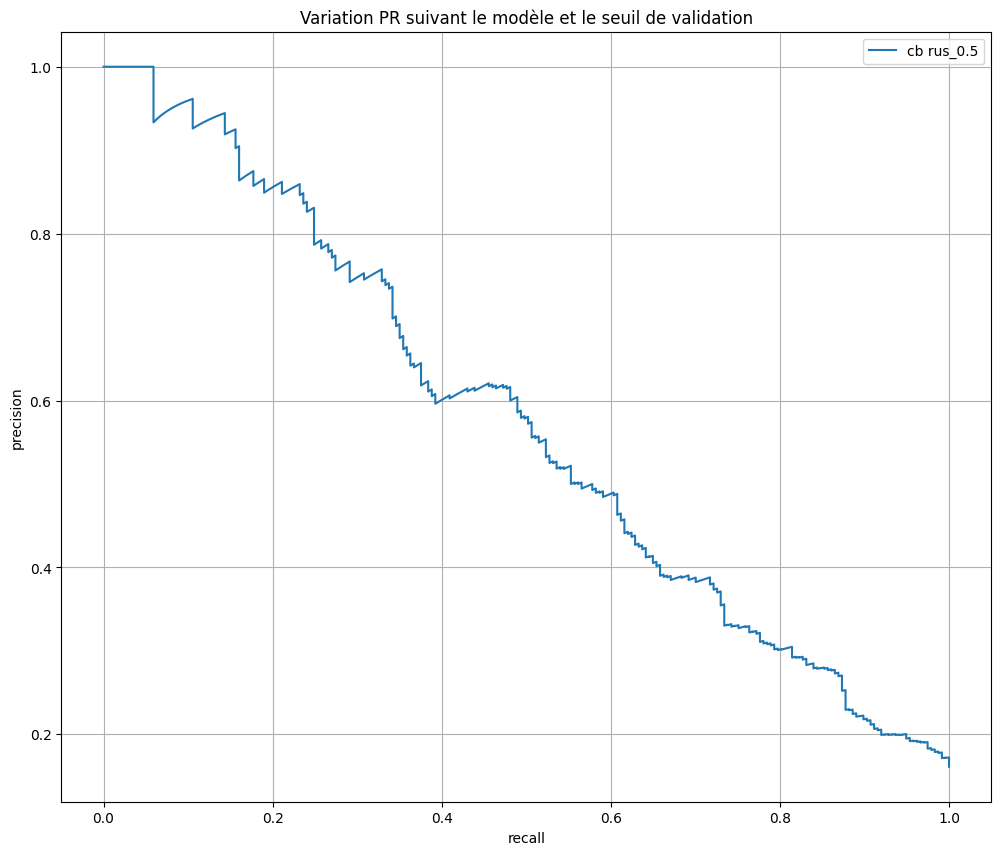

In [50]:
# Courbe PR (même résultat mais fonction différente juste) -- Recherche d'un seuil de validation optimisé
threshold_tuning_dict = []

plt.figure(figsize=(12,10))
precision,recall,thresholds = precision_recall_curve(y,df_cb_y_pred_rus05_thresh05.loc[0,'y_pred_proba'][:,1])
idx = np.argmin(np.abs(recall-target_recall)) # On relève l'indice de l'écart min recall/recall cible
opt_threshold = thresholds[idx] if idx < len(thresholds) else 1.0
name = f'{df_cb_y_pred_rus05_thresh05.loc[0,'Modele']} {'rus_0.5'}'
threshold_tuning_dict.append({
    'Nom': name,
    'Précision' : precision[idx],
    'Rappel': recall[idx],
    'Seuil_optimal' : opt_threshold
})

plt.plot(recall,precision,label=name)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Variation PR suivant le modèle et le seuil de validation')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
# target_recall = 0.7
# idx = np.argmin(np.abs(recall-target_recall))
# opt_threshold = thresholds[idx] if idx < len(thresholds) else 1.0
# print(f' Seuil optimal: {opt_threshold}, Précision = {precision[idx]} et Rappel = {recall[idx]}')
threshold_tuning_df = pd.DataFrame(threshold_tuning_dict)
threshold_tuning_df.loc[threshold_tuning_df['Nom'] == 'cb rus_0.5']

,Nom,Précision,Rappel,Seuil_optimal
0,cb rus_0.5,0.382488,0.700422,0.295898


- Précision: Sur 100 démissionaire prédit, seuls 38 le sont vraiment
- Rappel: Sur 100 démissionaires, le modèle en détecte 70.

DONC pour avoir les 237 démissionaires, il faudrait théoriquement que le modèle prédisent un total d'environ 620 démissionaires 

In [36]:
thresh_opt = threshold_tuning_df.loc[threshold_tuning_df['Nom'] == 'cb rus_0.5','Seuil_optimal'].values
# thresh_opt

In [37]:
# Dictionnaire pour stocker les différents résultats
print(f'===========Modèle: {threshold_tuning_df['Nom']} et seuil de validation: {thresh_opt}===========')
df_cb_y_threshold_opt = cat_modeling_cv_predict(
    X,
    y,
    numeric_list,
    cat_list,
    models_full=model_opt,
    scaler_tf = scaler_tf_opt,
    cv = cv,
    show=True,
    class_threshold = thresh_opt,
    add_pipe = {'rus':RandomUnderSampler(sampling_strategy=0.5, random_state=random_state)}
)

===========Modèle: 0    cb rus_0.5
Name: Nom, dtype: object et seuil de validation: [0.29589821]===========
Modèle : cb en cours


,Modele,y_pred_proba,y_pred
0,cb,"[[0.4323990308288572, 0.5676009691711428], [0....","[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, ..."


In [38]:
print(f'Matrice de confusion ([True Negative, False Positive],\n'\
f'                      [False Negative, True Positive]) \nModèle:{'cb'}\nSource:{threshold_tuning_df['Nom']}\nSeuil_opt:{thresh_opt}')

display(confusion_matrix(y,pd.Series(df_cb_y_threshold_opt.loc[0,'y_pred'])))

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modèle:cb
Source:0    cb rus_0.5
Name: Nom, dtype: object
Seuil_opt:[0.29589821]


array([[965, 268],
       [ 71, 166]])

Par rapport au cas par défaut (sans sous echantillonnage et sans optimisation de seuil) on observe les points suivants:
- +100% de TP,
- -50% de FN,
- +788% de FP,
- -20% de TN

On a très fortement augmenter le nombre d'erreur sur les employés non-démissionnaires (par un facteur 8) mais on a aussi multiplié par 2 la détéction des vrais démissionaires. On détecte comme prévu 70% des vrais démissionaires au dépend d'un nombre accru d'erreurs sur les employés qui restent en poste qui représentent 6 personnes sur 10.

<span style='color:red;font-size:1.5em;font-weight:bold'> Warning: il semblerait que la pondération via l'hyperparamètre class_weights aurait pu permettre de ne pas réaliser d'échantillonnage et aurait été une meilleure solution, on va donc regarder si c'est le cas et si on peut donc remplacer rus par cette méthode  </span>

<span style='color:blue;font-size:1.5em;font-weight:bold;background-color:yellow'> Pondération VS Echantillonnage </span>

In [39]:
# Dictionnaire pour stocker les différents résultats
comparison_results_cv_dict_cb_weighted = {}

# La strategie de pondération à appliquée [majo,mino]
weight_strat = [None, 'Balanced', 'SqrtBalanced']

for weight in weight_strat:
    
    model_opt_weight = {
        'cb':CatBoostClassifier(
        auto_class_weights = weight,
        random_state = random_state,#defaut = None
        logging_level='Silent' # Evite de printer 1 milliard de ligne de progression
                           )
    }
    
    print(f'===========Strategie de pondération: {weight}===========')
    comparison_results_cv_dict_cb_weighted[f'{weight}'] = cat_modeling_cv(
        X,
        y,
        numeric_list,
        cat_list,
        models_full = model_opt_weight,
        scaler_tf = scaler_tf_opt,
        show=False,
        scoring=scoring_cb,
    )[4] # Ne relève que le dataframe

===========Strategie de pondération: None===========
Modèle : cb en cours
===========Strategie de pondération: Balanced===========
Modèle : cb en cours
===========Strategie de pondération: SqrtBalanced===========
Modèle : cb en cours


In [40]:
# Regroupement des combinaisons dans une seule dataframe
comparison_results_cv_concat_cb_weighted = pd.concat(
    [df.assign(Source=key) for key, df in comparison_results_cv_dict_cb_weighted.items()], 
    ignore_index=True
)
comparison_results_cv_concat_cb_weighted

,Modele,balanced_accu_train,balanced_accu_test,prec_train,prec_test,recall_train,recall_test,Source
0,cb,0.941980,0.640664,1.000000,0.791752,0.883960,0.295922,None
1,cb,0.997364,0.707344,0.973398,0.594099,1.000000,0.477128,Balanced
2,cb,0.993890,0.663169,0.996819,0.681825,0.988388,0.358777,SqrtBalanced


Suivant le recall, on va choisir la méthode balanced

In [41]:
model_cb_balanced = {
        'cb':CatBoostClassifier(
        auto_class_weights = 'Balanced',
        random_state = random_state,#defaut = None
        logging_level='Silent' # Evite de printer 1 milliard de ligne de progression
                           )
    }

In [42]:
print(f'===========Méthode de pondération: {'Balanced'} et seuil de validation: {0.5}===========')
df_cb_y_pred_balanced_thresh05 = cat_modeling_cv_predict(
    X,
    y,
    numeric_list,
    cat_list,
    models_full=model_cb_balanced,
    scaler_tf = scaler_tf_opt,
    cv = cv,
    show=True,
    class_threshold = 0.5,
)

===========Méthode de pondération: Balanced et seuil de validation: 0.5===========
Modèle : cb en cours


,Modele,y_pred_proba,y_pred
0,cb,"[[0.399696556561984, 0.600303443438016], [0.91...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."


In [43]:
print(f'Matrice de confusion ([True Negative, False Positive],\n'\
f'                      [False Negative, True Positive]) \nModèle:{'cb'}\nSource:{'Balanced'}\nSeuil:0.5')

display(confusion_matrix(y,pd.Series(df_cb_y_pred_balanced_thresh05.loc[0,'y_pred'])))

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modèle:cb
Source:Balanced
Seuil:0.5


array([[1156,   77],
       [ 124,  113]])

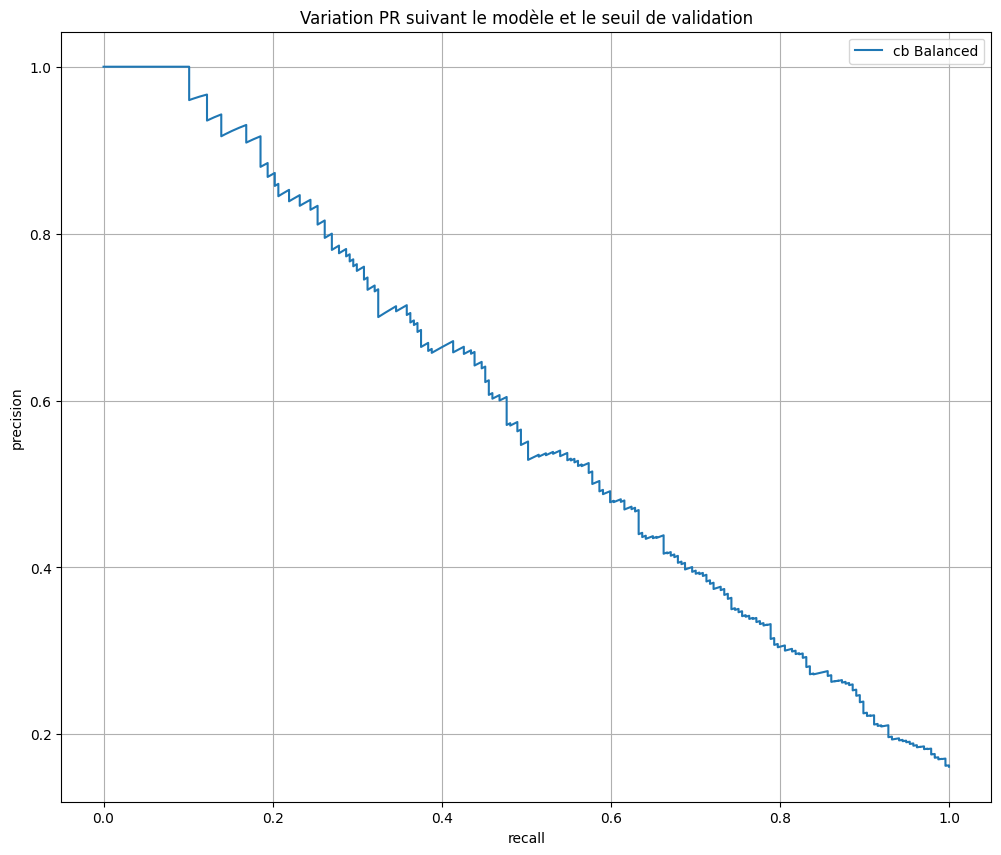

In [49]:
# Courbe PR (même résultat mais fonction différente juste) -- Recherche d'un seuil de validation optimisé
threshold_tuning_dict_weighted = []

plt.figure(figsize=(12,10))
precision,recall,thresholds = precision_recall_curve(y,df_cb_y_pred_balanced_thresh05.loc[0,'y_pred_proba'][:,1])
idx = np.argmin(np.abs(recall-target_recall)) # On relève l'indice de l'écart min recall/recall cible
opt_threshold = thresholds[idx] if idx < len(thresholds) else 1.0
name = f'{df_cb_y_pred_balanced_thresh05.loc[0,'Modele']} {'Balanced'}'
threshold_tuning_dict_weighted.append({
    'Nom': name,
    'Précision' : precision[idx],
    'Rappel': recall[idx],
    'Seuil_optimal' : opt_threshold
})

plt.plot(recall,precision,label=name)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Variation PR suivant le modèle et le seuil de validation')
plt.grid(True)
plt.legend()
plt.show()

In [45]:
threshold_tuning_df_weighted = pd.DataFrame(threshold_tuning_dict_weighted)
threshold_tuning_df_weighted.loc[threshold_tuning_df_weighted['Nom'] == 'cb Balanced']

,Nom,Précision,Rappel,Seuil_optimal
0,cb Balanced,0.392435,0.700422,0.269441


In [46]:
thresh_opt_weighted = threshold_tuning_df_weighted.loc[threshold_tuning_df_weighted['Nom'] == 'cb Balanced','Seuil_optimal'].values

In [47]:
# Dictionnaire pour stocker les différents résultats
print(f'===========Modèle: {threshold_tuning_df_weighted['Nom']} et seuil de validation: {thresh_opt_weighted}===========')
df_cb_y_threshold_opt_weighted = cat_modeling_cv_predict(
    X,
    y,
    numeric_list,
    cat_list,
    models_full=model_cb_balanced,
    scaler_tf = scaler_tf_opt,
    cv = cv,
    show=True,
    class_threshold = thresh_opt_weighted,
)

===========Modèle: 0    cb Balanced
Name: Nom, dtype: object et seuil de validation: [0.26944141]===========
Modèle : cb en cours


,Modele,y_pred_proba,y_pred
0,cb,"[[0.399696556561984, 0.600303443438016], [0.91...","[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, ..."


In [48]:
print(f'Matrice de confusion ([True Negative, False Positive],\n'\
f'                      [False Negative, True Positive]) \nModèle:{'cb'}\nSource:{threshold_tuning_df_weighted['Nom']}\nSeuil_opt:{thresh_opt_weighted}')

display(confusion_matrix(y,pd.Series(df_cb_y_threshold_opt_weighted.loc[0,'y_pred'])))

Matrice de confusion ([True Negative, False Positive],
                      [False Negative, True Positive]) 
Modèle:cb
Source:0    cb Balanced
Name: Nom, dtype: object
Seuil_opt:[0.26944141]


array([[976, 257],
       [ 71, 166]])

La combinaison pondération balanced + le threshold donne un résultat légèrement meilleur qu'avec l'échantillonnage à 0.5 ce qui est plus intéressante car, on ne se déleste pas de données.On va donc plutôt **partir sur la méthode de pondération**.

Remarque: Dans la littérature il est déconseillé de réaliser le threshold avec SMOTE (ou de facon général l'oversampling?) car cela va induire de l'instabilité de plus, réaliser la pondération et un échantillonnage est aussi fortement déconseillé.

<span style='color:blue;font-size:1.5em;font-weight:bold;background-color:yellow'> Choix du modèle non-linéaire </span>

On va partir sur **CatBoostClassifier avec une pondération "balanced" et un seuil de validation de 0.26944141**